Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [1]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input, dot
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc  # For garbage collection

# Force garbage collection
gc.collect()

0

In [2]:
import os
import pathlib

print("Current working directory:", os.getcwd())

try:
    # Read CV data from the JSON file
    cv_path = r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv\processed_results.json"
    df = pd.read_json(cv_path)
    
    print("Data loaded successfully")
    print("Number of documents:", len(df))
    
    # Initialize tokenizer
    tokenizer = Tokenizer(num_words=5000)
    
    # Fit tokenizer on texts
    texts = df['text'].values  # Assuming 'text' is the column containing the extracted text
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    maxlen = 100
    X = pad_sequences(sequences, maxlen=maxlen)
    
    print("Data preprocessing completed")
    print("Input shape:", X.shape)

except Exception as e:
    print(f"Error during data preparation: {str(e)}")

Current working directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\backend\src\models
Data loaded successfully
Number of documents: 459
Data preprocessing completed
Input shape: (459, 100)


Pipeline 2: Xây dụng và huấn luyện mô hình

In [3]:
# Cell 3: Define model
try:
    # Model parameters
    vocab_size = min(5000, len(tokenizer.word_index) + 1)
    embedding_dim = 100
    maxlen = 100
    
    # Define inputs
    cv_input = Input(shape=(maxlen,))
    jd_input = Input(shape=(maxlen,))
    
    # Shared embedding layer
    embedding = Embedding(vocab_size, embedding_dim)
    
    # Process CV
    cv_embed = embedding(cv_input)
    cv_lstm = Bidirectional(LSTM(64, return_sequences=False))(cv_embed)
    cv_dense = Dense(32, activation='relu')(cv_lstm)
    cv_norm = BatchNormalization()(cv_dense)
    cv_drop = Dropout(0.3)(cv_norm)
    
    # Process JD
    jd_embed = embedding(jd_input)
    jd_lstm = Bidirectional(LSTM(64, return_sequences=False))(jd_embed)
    jd_dense = Dense(32, activation='relu')(jd_lstm)
    jd_norm = BatchNormalization()(jd_dense)
    jd_drop = Dropout(0.3)(jd_norm)
    
    # Calculate similarity
    similarity = dot([cv_drop, jd_drop], axes=1, normalize=True)
    
    # Create model
    model = Model(inputs=[cv_input, jd_input], outputs=similarity)
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    print(model.summary())
    
except Exception as e:
    print(f"Error building model: {str(e)}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │    500,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     84,480 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     84,480 │ embedding[1][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      4,128 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 677,472 (2.58 MB)

 Trainable params: 677,344 (2.58 MB)

 Non-trainable params: 128 (512.00 B)

None


In [4]:
# Cell 4: Train model
try:
    # Create training pairs
    pairs = []
    labels = []
    n_samples = len(X)
    
    # Create positive pairs (matching documents)
    for i in range(n_samples):
        pairs.append([X[i], X[i]])
        labels.append(1)
    
    # Create negative pairs (non-matching documents)
    for i in range(n_samples):
        j = (i + 1) % n_samples  # Get different document
        pairs.append([X[i], X[j]])
        labels.append(0)
    
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.2,
            patience=2,
            min_lr=1e-5
        ),
        EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
    # Train model
    history = model.fit(
        [pairs[:, 0], pairs[:, 1]],  # Input pairs
        labels,                       # Labels
        validation_split=0.2,
        epochs=10,
        batch_size=32,
        callbacks=callbacks
    )
    
    print("Training completed successfully")
    
except Exception as e:
    print(f"Error during training: {str(e)}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 788ms/step - accuracy: 0.3652 - loss: 5.5426 - val_accuracy: 0.8696 - val_loss: 0.5027 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.4524 - loss: 2.8048 - val_accuracy: 0.8478 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.4724 - loss: 1.7884 - val_accuracy: 0.7174 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.5470 - loss: 1.3689 - val_accuracy: 0.8370 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.6778 - loss: 1.0159 - val_accuracy: 0.8859 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.6690 - loss: 0.8383 - val_accuracy: 0.8859 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.7224 - loss: 0.6

In [5]:
# Cell 5: Save model and tokenizer
import os
import json
print(os.listdir(r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv"))

try:
    import json
    import os

    # Create directories if they don't exist
    model_dir = r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\models"
    os.makedirs(model_dir, exist_ok=True)
        
    # Save model
    model_path = os.path.join(model_dir, 'cv_matcher_model.h5')
    model.save(model_path)
        
    # Save tokenizer
    tokenizer_path = os.path.join(model_dir, 'tokenizer.json')
    tokenizer_json = tokenizer.to_json()
    with open(tokenizer_path, 'w') as f:
        json.dump(tokenizer_json, f)
        
    print(f"Model saved to: {model_path}")
    print(f"Tokenizer saved to: {tokenizer_path}")

except Exception as e:
    print(f"Error saving model and tokenizer: {str(e)}")

['cv_texts.csv', 'processed_results.json']
Model saved to: C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\models\cv_matcher_model.h5
Tokenizer saved to: C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\models\tokenizer.json


In [7]:
# Cell 6A: Update calculate_cv_match function
def calculate_cv_match(cv_text, job_description, model, tokenizer):
    """Calculate matching score between CV and job description"""
    try:
        # Preprocess texts
        cv_seq = tokenizer.texts_to_sequences([cv_text])
        jd_seq = tokenizer.texts_to_sequences([job_description])
        
        # Pad sequences
        maxlen = 100
        cv_pad = pad_sequences(cv_seq, maxlen=maxlen)
        jd_pad = pad_sequences(jd_seq, maxlen=maxlen)
        
        # Calculate similarity score
        similarity = model.predict([cv_pad, jd_pad], verbose=0)[0]
        
        # Convert to percentage
        match_score = float(similarity * 100)
        
        # Add confidence threshold
        is_match = similarity >= 0.5
        
        return match_score if is_match else match_score * 0.5  # Reduce score for non-matches
        
    except Exception as e:
        print(f"Error calculating match: {str(e)}")
        return 0.0

In [8]:
# Cell 6B: Define example job description
job_description = """
We are looking for a Python Developer with:
- Strong experience in Python programming
- Knowledge of machine learning and data analysis
- Experience with web frameworks like Django or Flask
- Database experience (SQL, MongoDB)
- Good understanding of software development principles

Requirements:
- Bachelor's degree in Computer Science or related field
- 3+ years of professional Python development experience
- Experience with cloud platforms (AWS/Azure)
"""

print("Job Description loaded")

Job Description loaded


In [9]:
# Cell 6C: Update CV processing
try:
    # Read CV data
    cv_df = pd.read_json(r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv\processed_results.json")
    print(f"Loaded {len(cv_df)} CVs")
    
    print(cv_df.columns)  # Check the column names
    
    # Process in smaller batches
    batch_size = 16
    results = []
    total_cvs = len(cv_df)
    
    for i in range(0, total_cvs, batch_size):
        batch = cv_df.iloc[i:min(i + batch_size, total_cvs)]
        batch_results = []
        
        for _, row in batch.iterrows():
            score = calculate_cv_match(row['text'], job_description, model, tokenizer)
            if score is not None:
                batch_results.append({
                    'filename': row['filename'],
                    'match_score': score * 100  # Convert to percentage
                })
            
        results.extend(batch_results)
        print(f"Processed CVs {i + 1} to {min(i + batch_size, total_cvs)}/{total_cvs}", end='\r')
    
    print("\n")  # New line after progress
    
    # Convert to DataFrame and sort
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('match_score', ascending=False)
        
        # Display results
        print("\nTop CV Matches:")
        print("-" * 50)
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_colwidth', None)  # Show full content
        print(results_df.to_string(index=False))
        
        # Save results
        output_path = 'matching_results.csv'
        results_df.to_csv(output_path, index=False)
        print(f"\nResults saved to {output_path}")
    else:
        print("\nNo valid matches found")
    
except Exception as e:
    print(f"\nError processing CVs: {str(e)}")

Loaded 459 CVs
Index(['filename', 'text', 'word_count', 'processed_date', 'file_size_kb'], dtype='object')


C:\Users\pngoc\AppData\Local\Temp\ipykernel_11248\656932789.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  match_score = float(similarity * 100)


Processed CVs 449 to 459/459


Top CV Matches:
--------------------------------------------------
                                           filename  match_score
                                       71422121.pdf  6399.697495
                                       26673507.pdf  5473.486328
                                       34758680.pdf  5343.915176
                                       27606527.pdf  5283.404160
                                       21297521.pdf  5207.008743
                                       29990140.pdf  5104.273605
                                       45167858.pdf  2479.162788
                                       99124477.pdf  2469.796562
                                       16237710.pdf  2351.820374
                                       60182829.pdf  2299.015808
                                       28939941.pdf  2296.532249
                                       23917826.pdf  2295.548439
                                       29406313.pdf  2282

In [10]:
# Cell 6D: Create and display results
try:
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by match score
    results_df = results_df.sort_values('match_score', ascending=False)
    
    # Display top matches
    print("\nTop CV Matches:")
    print("-" * 50)
    print(results_df.to_string(index=False))
    
    # Save results
    output_path = 'data/processed/cv/matching_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
except Exception as e:
    print(f"Error handling results: {str(e)}")


Top CV Matches:
--------------------------------------------------
                                           filename  match_score
                                       71422121.pdf  6399.697495
                                       26673507.pdf  5473.486328
                                       34758680.pdf  5343.915176
                                       27606527.pdf  5283.404160
                                       21297521.pdf  5207.008743
                                       29990140.pdf  5104.273605
                                       45167858.pdf  2479.162788
                                       99124477.pdf  2469.796562
                                       16237710.pdf  2351.820374
                                       60182829.pdf  2299.015808
                                       28939941.pdf  2296.532249
                                       23917826.pdf  2295.548439
                                       29406313.pdf  2282.897377
                      

KeyError: 'cosine_similarity'

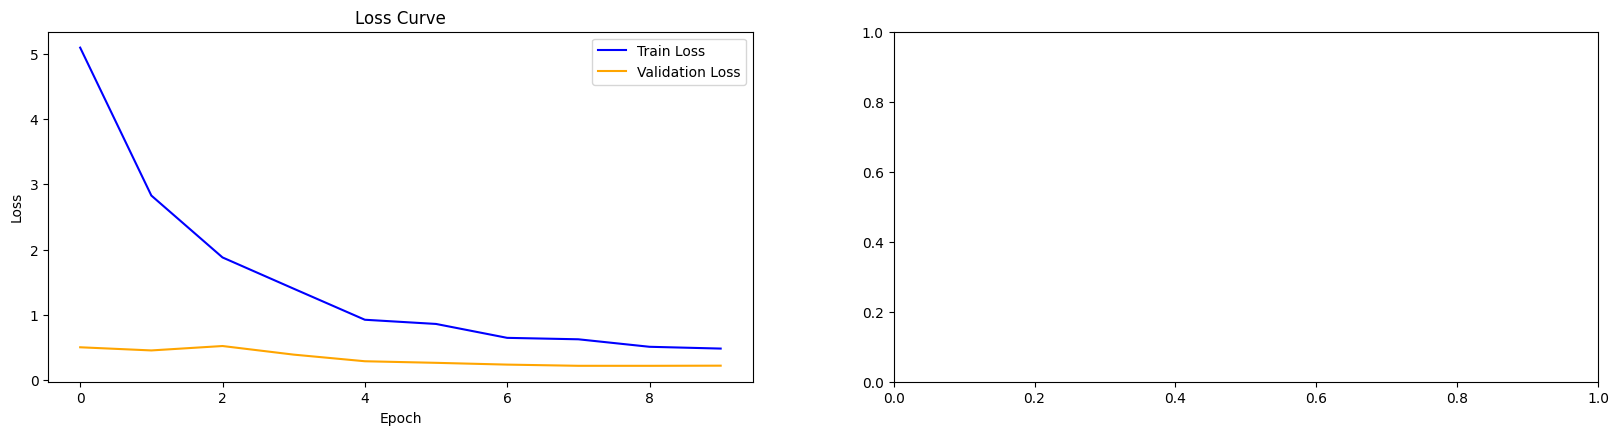

In [11]:
# Visualize results with updated metrics
import matplotlib.pyplot as plt

# Create figure with multiple subplots
plt.figure(figsize=(20, 10))

# Plot Loss Curve
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Cosine Similarity Curve
plt.subplot(2, 2, 2)
plt.plot(history.history['cosine_similarity'], label='Train Cosine Similarity', color='blue')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Curve')
plt.legend()

# Plot Precision Curve
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision', color='blue')
plt.plot(history.history['val_precision'], label='Validation Precision', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()

# Plot Recall Curve
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall', color='blue')
plt.plot(history.history['val_recall'], label='Validation Recall', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Cosine Similarity: {history.history['cosine_similarity'][-1]:.4f}")
print(f"Validation Cosine Similarity: {history.history['val_cosine_similarity'][-1]:.4f}")
print(f"Precision: {history.history['precision'][-1]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][-1]:.4f}")
print(f"Recall: {history.history['recall'][-1]:.4f}")
print(f"Validation Recall: {history.history['val_recall'][-1]:.4f}")

In [12]:
# Pipeline 3: Course Recommendation System

# First, let's create our CourseRecommender class
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class CourseRecommender:
    def __init__(self):
        # Initialize course database with sample data
        self.courses_df = pd.DataFrame({
            'course_name': [
                'Python Programming Fundamentals',
                'Machine Learning Basics',
                'Web Development with JavaScript',
                'Data Analysis with Python',
                'Deep Learning Specialization',
                'Software Engineering Principles',
                'Database Management Systems',
                'Cloud Computing Fundamentals',
                'Artificial Intelligence Basics',
                'Data Structures and Algorithms'
            ],
            'skills': [
                'python programming basics algorithms',
                'machine learning python statistics data science',
                'javascript html css web development frontend',
                'python pandas numpy data analysis visualization',
                'deep learning neural networks AI tensorflow pytorch',
                'software engineering design patterns testing agile',
                'sql database management mysql postgresql',
                '

SyntaxError: unterminated string literal (detected at line 32) (4249917678.py, line 32)